In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.io import savemat,loadmat
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.dpi'] = 150 
# get_ipython().run_line_magic('matplotlib', 'inline')

from itertools import combinations_with_replacement, product
from sklearn.decomposition import SparseCoder
from tqdm.notebook import trange
import sys,time
import os
import copy
import pickle
from IPython.display import HTML

import pysindy as ps

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Fri Aug  6 21:37:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   45C    P0    55W / 300W |  15288MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   47C    P0    57W / 300W |    430MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
sample = 25 # 4,9,25
LS_dim = 3

In [4]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

# Given parameters
nx = 60
ny = 60
m = (ny-2)*(nx-2) # 3364
nt = 1500
tstop = 2
dt = tstop/nt

# In[17]:


# Choose either Re=10000 or Re=100
Re = 10000 
    
# Choose data normalize option (option 1: -1<=X<=1 option 2: 0<=X<=1)
option = 2

# Choose activation function (sigmoid, swish)
activation = 'sigmoid'


# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer

f = LS_dim # latent dimension

def create_mask_2d(m,b,db):
    
    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block
    
    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )
    
    return mask
mask_2d=create_mask_2d(m,b,db)


if activation=='sigmoid':
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                nn.Sigmoid(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                nn.Sigmoid(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
        
elif activation=='swish':
    def silu(input):
        return input * torch.sigmoid(input)

    class SiLU(nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, input):
            return silu(input)
        
    class Encoder(nn.Module):
        def __init__(self,m,M1,f):
            super(Encoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(m,M1),
                SiLU(),
                nn.Linear(M1,f,bias=False)
            )

        def forward(self, y):     
            y = y.view(-1,m)
            T = self.full(y)
            T = T.squeeze()

            return T

    class Decoder(nn.Module):
        def __init__(self,f,M2,m):
            super(Decoder,self).__init__()
            self.full = nn.Sequential(
                nn.Linear(f,M2),
                SiLU(),
                nn.Linear(M2,m,bias=False)
            )

        def forward(self,T):
            T = T.view(-1,f)
            y = self.full(T)
            y = y.squeeze()

            return y
else:
    raise NameError('{} is given for option, but it must be either sigmoid or swish'.format(activation))

Using device: cuda 

Sparsity in 3364 by 33730 mask: 99.06%


In [5]:
model_u = torch.load('../../../../../usr/WS1/fries4/Experiments/2DBurgers/model/AE_u_{}_dim_{}.tar'.format(int(sample), LS_dim), map_location=device)    
encoder_u = Encoder(m,M1,f).to(device); decoder_u = Decoder(f,M2,m).to(device)
prune.custom_from_mask(decoder_u.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
encoder_u.load_state_dict(model_u['encoder_state_dict']); decoder_u.load_state_dict(model_u['decoder_state_dict'])


model_v = torch.load('../../../../../usr/WS1/fries4/Experiments/2DBurgers/model/AE_v_{}_dim_{}.tar'.format(int(sample), LS_dim), map_location=device)    
encoder_v = Encoder(m,M1,f).to(device); decoder_v = Decoder(f,M2,m).to(device)
prune.custom_from_mask(decoder_v.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))    
encoder_v.load_state_dict(model_v['encoder_state_dict']); decoder_v.load_state_dict(model_v['decoder_state_dict'])

<All keys matched successfully>

In [6]:
snapshot = pickle.load(open("../../../../../usr/WS1/fries4/Experiments/2DBurgers/data/snapshot_{}.p".format(int(sample)), 'rb'))

snapshot_u = snapshot['u'].reshape(-1,nx*ny).astype('float32')
snapshot_v = snapshot['v'].reshape(-1,nx*ny).astype('float32')
ndata = snapshot_u.shape[0]

nset = round(ndata/(nt+1))

# remove BC
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

orig_data_u = snapshot_u[:,free_raveled_indicies]
orig_data_v = snapshot_v[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

# k=-1
# fig = plt.figure()
# ax_u = fig.add_subplot(1,1,1,projection = '3d')
# ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_u.view_init(elev=30,azim=30)
# ax_u.set_xlabel('$x_{free}$')
# ax_u.set_ylabel('$y_{free}$')


# fig = plt.figure()
# ax_v = fig.add_subplot(1,1,1,projection = '3d')
# ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[k].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
# ax_v.view_init(elev=30,azim=60)
# ax_v.set_xlabel('$x_{free}$')
# ax_v.set_ylabel('$y_{free}$')

# def animate(j):
#     ax_u.clear()
#     ax_v.clear()
#     ax_u.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_u[5*j].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_u.view_init(elev=30,azim=30)
#     ax_v.plot_surface(x_free.reshape(ny-2,nx-2), y_free.reshape(ny-2,nx-2), orig_data_v[5*j].reshape(ny-2,nx-2),cmap=cm.viridis, rstride=1, cstride=1)
#     ax_v.view_init(elev=30,azim=60)
#     ax_u.set_zlim(0,1)
#     ax_v.set_zlim(0,1)
    
    
# anim = animation.FuncAnimation(fig,animate,frames = int(nt/5), interval = 30)

In [7]:
# HTML(anim.to_html5_video())

# Latent Space
## Discovering the Dynamics

In [8]:
latent_space_SS_u = []
latent_space_SS_v = []

for foo in range(nset):
    input_SS_u=torch.tensor(orig_data_u[foo*(nt+1):(foo+1)*(nt+1)]).to(device)
    input_SS_v=torch.tensor(orig_data_u[foo*(nt+1):(foo+1)*(nt+1)]).to(device)
    latent_space_u = encoder_u(input_SS_u).cpu().detach().numpy()
    latent_space_v = encoder_v(input_SS_u).cpu().detach().numpy()
    latent_space_SS_u.append(latent_space_u)
    latent_space_SS_v.append(latent_space_v)

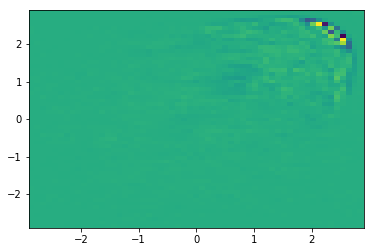

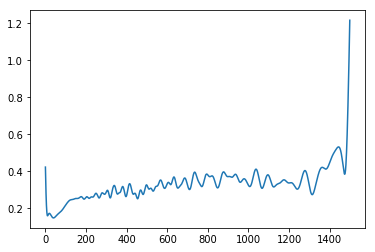

In [9]:
recon = decoder_u(encoder_u(input_SS_u)).cpu().detach().numpy()
u_full = orig_data_u[foo*(nt+1):(foo+1)*(nt+1)]
k=-1
fig = plt.figure()
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),recon[k].reshape(nx-2,ny-2)-u_full[k].reshape(nx-2,ny-2), shading = 'nearest')
test = []
for k in range(int(nt)):
    test.append(LA.norm(recon[k].reshape(ny-2,nx-2)-u_full[k].reshape(ny-2,nx-2))/LA.norm(u_full[k].reshape(ny-2,nx-2))*100)
fig = plt.figure()
plt.plot(test)


In [10]:
u_full.shape

(1501, 3364)

In [11]:
degree_u = 4 ; degree_v = 3
interact = False
normal_u = np.amax(np.abs(latent_space_SS_u)); normal_v = np.amax(np.abs(latent_space_SS_v))
data_u = []
data_v = []
for i in range(nset):
    data_u.append(latent_space_SS_u[i]/normal_u)
    data_v.append(latent_space_SS_v[i]/normal_v)
t=np.linspace(0,2,1500)

In [12]:
poly_library = ps.PolynomialLibrary(include_interaction=True, degree = degree_u)
optim = ps.STLSQ(threshold=0, alpha=0, copy_X=True, fit_intercept=False, max_iter=20, normalize=False, ridge_kw=None)
model_u_PS = ps.SINDy(feature_library = poly_library, optimizer = optim)
model_u_PS.fit(data_u, t = dt, multiple_trajectories = True)
model_u_PS.print()
print('')
poly_library = ps.PolynomialLibrary(include_interaction=True, degree = degree_v)
optim = ps.STLSQ(threshold=0, alpha=0, copy_X=True, fit_intercept=False, max_iter=20, normalize=False, ridge_kw=None)
model_v_PS = ps.SINDy(feature_library = poly_library, optimizer = optim)
model_v_PS.fit(data_v, t = dt, multiple_trajectories = True)
model_v_PS.print()

x0' = 0.198 1 + 0.715 x0 + -11.586 x1 + -3.117 x2 + -4.252 x0^2 + -45.722 x0 x1 + -23.017 x0 x2 + 7.075 x1^2 + -20.570 x1 x2 + 10.710 x2^2 + -12.285 x0^3 + -58.372 x0^2 x1 + -64.405 x0^2 x2 + 29.718 x0 x1^2 + -29.544 x0 x1 x2 + -25.677 x0 x2^2 + -38.153 x1^3 + -3.803 x1^2 x2 + 48.577 x1 x2^2 + -74.241 x2^3 + -8.251 x0^4 + -22.119 x0^3 x1 + -51.660 x0^3 x2 + 11.276 x0^2 x1^2 + -2.416 x0^2 x1 x2 + -62.702 x0^2 x2^2 + -46.264 x0 x1^3 + -97.280 x0 x1^2 x2 + 36.620 x0 x1 x2^2 + -89.403 x0 x2^3 + 39.695 x1^4 + 35.885 x1^3 x2 + -186.130 x1^2 x2^2 + 9.275 x1 x2^3 + 32.150 x2^4
x1' = 0.227 1 + 8.284 x0 + 1.932 x1 + 8.622 x2 + 30.904 x0^2 + -12.530 x0 x1 + 48.159 x0 x2 + 30.780 x1^2 + -8.705 x1 x2 + 18.177 x2^2 + 43.500 x0^3 + -49.627 x0^2 x1 + 104.290 x0^2 x2 + 133.382 x0 x1^2 + -80.233 x0 x1 x2 + 72.920 x0 x2^2 + -77.189 x1^3 + 46.810 x1^2 x2 + -81.606 x1 x2^2 + 14.393 x2^3 + 20.848 x0^4 + -39.217 x0^3 x1 + 72.361 x0^3 x2 + 124.502 x0^2 x1^2 + -105.882 x0^2 x1 x2 + 97.234 x0^2 x2^2 + -137.537 

/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.97987e-09): result may not be accurate.
  overwrite_a=True).T
/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.97987e-09): result may not be accurate.
  overwrite_a=True).T
/g/g15/fries4/GitHub/NM-ROM/nm-rom/lib/python3.7/site-packages/scikit_learn-0.24.2-py3.7-linux-ppc64le.egg/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.97987e-09): result may not be accurate.
  overwrite_a=True).T


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20028feedc18> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20028feedd68> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20028feda940> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20028fe

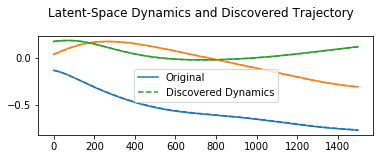

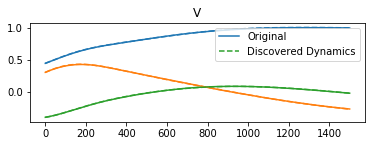

In [13]:
fig = plt.figure()
fig.suptitle('Latent-Space Dynamics and Discovered Trajectory')
ax_u = fig.add_subplot(2,1,1)
# ax_u.set_title('U')
for i in [-1]:
    ax_u.plot(data_u[i], )
    X_sim_u = model_u_PS.simulate(data_u[i][0], t)
    plt.gca().set_prop_cycle(None)

ax_u.plot(np.linspace(0,nt,nt),X_sim_u,'--')
labels = ['Original', '_nolegend','_nolegend','_nolegend','_nolegend', 'Discovered Dynamics']
ax_u.legend(labels)

fig = plt.figure()
ax_v = fig.add_subplot(2,1,1)
ax_v.set_title('V')
for i in [0]:
    ax_v.plot(data_v[i])
    X_sim_v = model_v_PS.simulate(data_v[i][0], t)
    plt.gca().set_prop_cycle(None)
ax_v.plot(np.linspace(0,nt,nt),X_sim_v,'--')
labels = ['Original', '_nolegend','_nolegend','_nolegend','_nolegend', 'Discovered Dynamics']
ax_v.legend(labels)

In [14]:
Max_Error = 0
for i in range(len(data_u)):
    X_sim = model_u_PS.simulate(data_u[i][0], t)
    Error = LA.norm((X_sim-data_u[i][:-1])**2/np.prod(X_sim.shape))
    if Error > Max_Error:
        Max_Error = Error
    print("MSE for Simulation {}: {}".format(i, Error))
print("")
print('Max MSE: {}'.format(Max_Error))

MSE for Simulation 0: 4.857382840173092e-08
MSE for Simulation 1: 2.379205937301341e-08
MSE for Simulation 2: 1.736060507229751e-08
MSE for Simulation 3: 1.0503883198604889e-08
MSE for Simulation 4: 2.0463687953344244e-08
MSE for Simulation 5: 1.7488157315752695e-08
MSE for Simulation 6: 7.936831908479276e-09
MSE for Simulation 7: 1.1608195586699495e-08
MSE for Simulation 8: 2.7277590477492447e-08
MSE for Simulation 9: 5.185425795537987e-08
MSE for Simulation 10: 4.742658948970465e-08
MSE for Simulation 11: 2.315693287305139e-08
MSE for Simulation 12: 2.886472199667508e-08
MSE for Simulation 13: 4.073795010673551e-08
MSE for Simulation 14: 4.655382905398881e-08
MSE for Simulation 15: 3.987618881251133e-08
MSE for Simulation 16: 3.758499919708171e-08
MSE for Simulation 17: 2.3517190236919022e-08
MSE for Simulation 18: 2.3942667530587203e-08
MSE for Simulation 19: 2.617975516959962e-08
MSE for Simulation 20: 7.089585839459732e-08
MSE for Simulation 21: 4.042954312686276e-08
MSE for Simul

In [15]:
Max_Error = 0
for i in range(len(data_v)):
    X_sim = model_v_PS.simulate(data_v[i][0], t)
    Error = LA.norm((X_sim-data_v[i][:-1])**2/np.prod(X_sim.shape))
    if Error > Max_Error:
        Max_Error = Error
    print("MSE for Simulation {}: {}".format(i, Error))
print("")
print('Max MSE: {}'.format(Max_Error))

MSE for Simulation 0: 1.0699285373786094e-07
MSE for Simulation 1: 4.6142616752879445e-07
MSE for Simulation 2: 8.463805316285311e-07
MSE for Simulation 3: 9.672928271533159e-07
MSE for Simulation 4: 8.910764539964569e-07
MSE for Simulation 5: 1.4498131501572514e-07
MSE for Simulation 6: 8.271728789100508e-08
MSE for Simulation 7: 1.993744751851717e-07
MSE for Simulation 8: 2.7536653064886617e-07
MSE for Simulation 9: 3.465593566851689e-07
MSE for Simulation 10: 2.998206563563159e-07
MSE for Simulation 11: 5.866969446415565e-08
MSE for Simulation 12: 3.451857176986062e-08
MSE for Simulation 13: 6.940605912922219e-08
MSE for Simulation 14: 1.8439561366587407e-07
MSE for Simulation 15: 6.819697791748566e-07
MSE for Simulation 16: 2.734373925009837e-07
MSE for Simulation 17: 1.143240493980666e-07
MSE for Simulation 18: 6.899595976274737e-08
MSE for Simulation 19: 1.3817526599605644e-07
MSE for Simulation 20: 1.2261425180174316e-06
MSE for Simulation 21: 6.28247797509936e-07
MSE for Simula

## Mapping Parameters to Latent Space

In [17]:
amp_arr = np.linspace(.7,.9,int(np.sqrt(sample)))
width_arr = np.linspace(.9,1.1,int(np.sqrt(sample)))
P = list(product(amp_arr, width_arr))
P = np.array(P)

L_u = np.empty([len(data_u),f])
for i in range(len(data_u)):
    L_u[i,:] = data_u[i][0]
B_u = LA.lstsq(P, L_u, rcond = None)[0].T

L_v = np.empty([len(data_v),f])
for i in range(len(data_v)):
    L_v[i,:] = data_v[i][0]
B_v = LA.lstsq(P, L_v, rcond = None)[0].T

for i in range(P.shape[0]):
    IC_guess_u = np.matmul(B_u, P[i]).reshape(f)*normal_u
    IC_guess_v = np.matmul(B_v, P[i]).reshape(f)*normal_v
    print(LA.norm(latent_space_SS_u[i][0]-IC_guess_u)/LA.norm(latent_space_SS_u[i][0]))
    print(LA.norm(latent_space_SS_v[i][0]-IC_guess_v)/LA.norm(latent_space_SS_v[i][0]))

0.37884014341975697
0.277567167871081
0.2968322415011704
0.215152422730014
0.20215772681285918
0.1458330627942348
0.09300740925887832
0.06885859835252355
0.033316458121775964
0.01730213535306223
0.30773462991200523
0.223334316232839
0.21232258872819665
0.1538975380812234
0.10131583484589199
0.07630127861844684
0.028374254915653856
0.011595544592519814
0.1776226737399751
0.10780083383566237
0.23291373062780688
0.1678767562460014
0.12275743450249887
0.09088336232061002
0.00820166487390966
0.006030591711704292
0.15787510471147548
0.09355519174544144
0.33422636520723875
0.2030992679947901
0.15461210223411972
0.11119366118565323
0.02855343975599139
0.02621627767742021
0.12106446612210074
0.07065109126820036
0.2966666830314949
0.17972870250723746
0.5026508852545658
0.3030295777894848
0.07308382738048212
0.05328875943248598
0.07095691354661007
0.04086708255169643
0.2418166904985559
0.14778334070382976
0.44414625890062054
0.26949398005057507
0.6825508008120053
0.40772244832599847


## Interpolation and Extrapolation

In [18]:
amp = np.arange(.7,.9,.02)
width = np.arange(.9,1.1,.02)
max_re_approx = np.zeros([2,len(amp), len(width)])
max_re_exact = np.zeros([2,len(amp), len(width)])
speed_up_exact = np.zeros([len(amp), len(width)])
speed_up_approx = np.zeros([len(amp), len(width)])
speed_up_avg = np.empty([2,sample-1])
adapt_values = np.empty([4,sample-1])

for ii in range(2,sample):
    print(ii)
    row_count = -1
    for a in amp:
        row_count += 1
        col_count = -1
        for w in width:
            col_count += 1
            try:
                FOM_high_Re = pickle.load(open('../../../../../usr/WS1/fries4/Experiments/2DBurgers/data/Interp_Extrap/snapshot_full_amp_{}_width_{}.p'.format(int(100*a),int(100*w)),'rb'))
                u_full = FOM_high_Re['u']
                v_full = FOM_high_Re['v']
                time_FOM = FOM_high_Re['t']

                FOM_u = u_full.reshape(-1, nx*ny)
                FOM_v = v_full.reshape(-1,nx*ny)
            except:
                break
    #             time_FOM_start = time.time()
    #             FOM,FOM_inter = generate_dataset(np.array([a]), np.array([w]))
    #             time_FOM_stop = time.time()
    #             time_FOM = time_FOM_stop-time_FOM_start
    #             Save = {'FOM':FOM.astype('float32'), 't':time_FOM}
    #             pickle.dump(Save, open("../../../usr/WS1/fries4/Experiments/1DBurgers/data/Interp_Extrap/snapshot_full_amp_{}_width_{}.p".format(int(100*a),int(100*w)), "wb"))
            time_IC_start = time.time()

           ##########################################################################
           #### Uncomment this section to use k-closest training points in model ####
           #### [Specify k below]                                                ####

            dist = np.empty(P.shape[0])
            for i in range(P.shape[0]):
                dist[i]=(LA.norm(P[i]-np.array([a,w])))

            k=ii

            dist_index = np.argsort(dist)[0:k]
            L_u = np.empty([k,f])
            L_v = np.empty([k,f])
            
            local_u = []
            local_v = []
            j=-1
            for i in dist_index:
                j+=1
                L_u[j,:] = data_u[i][0]
                local_u.append(data_u[i])
                L_v[j,:] = data_v[i][0]
                local_v.append(data_v[i])
            B_u = LA.lstsq(np.array(P[dist_index]), L_u, rcond = None)[0].T
            B_v = LA.lstsq(np.array(P[dist_index]), L_v, rcond = None)[0].T
            model_u_PS.fit(local_u, t = dt, multiple_trajectories = True, quiet = True)
            model_v_PS.fit(local_v, t = dt, multiple_trajectories = True, quiet = True)

           ###########################################################################
        
            time_IC = time.time()-time_IC_start

            time_start = time.time()
            IC_guess_u = np.matmul(B_u, np.array([a,w])).reshape(f)
            latent_space_FOM_recon_u = torch.tensor(normal_u*model_u_PS.simulate(IC_guess_u, t).astype('float32')).to(device)
            recon_u = decoder_u(latent_space_FOM_recon_u).cpu().detach().numpy()

            IC_guess_v = np.matmul(B_v, np.array([a,w])).reshape(f)
            latent_space_FOM_recon_v = torch.tensor(normal_v*model_v_PS.simulate(IC_guess_v, t).astype('float32')).to(device)
            recon_v = decoder_v(latent_space_FOM_recon_v).cpu().detach().numpy()
            time_stop = time.time()
            
            time_SINDy = time_stop-time_start
            
            speed_up_approx[row_count,col_count] = time_FOM/time_SINDy            
            test = []
            for i in range(nt):
                test.append(LA.norm(recon_u[i]-FOM_u[i,free_raveled_indicies])/LA.norm(FOM_u[i,free_raveled_indicies]))
            max_re_approx[0,row_count,col_count]=np.amax(test)*100
            
            test = []
            for i in range(nt):
                test.append(LA.norm(recon_v[i]-FOM_v[i,free_raveled_indicies])/LA.norm(FOM_v[i,free_raveled_indicies]))
            max_re_approx[1,row_count,col_count]=np.amax(test)*100
            
            time_start = time.time()
            input_FOM_u=torch.tensor(FOM_u[0,free_raveled_indicies].astype('float32')).to(device)#-ref)
            IC_real_u = encoder_u(input_FOM_u).cpu().detach().numpy()
            
            input_FOM_v=torch.tensor(FOM_v[0,free_raveled_indicies].astype('float32')).to(device)#-ref)
            IC_real_v = encoder_v(input_FOM_v).cpu().detach().numpy()

            latent_space_FOM_recon_u = torch.tensor(normal_u*model_u_PS.simulate(IC_real_u/normal_u, t).astype('float32')).to(device)
            recon_u = decoder_u(latent_space_FOM_recon_u).cpu().detach().numpy()

            latent_space_FOM_recon_v = torch.tensor(normal_v*model_v_PS.simulate(IC_real_v/normal_v, t).astype('float32')).to(device)
            recon_v = decoder_v(latent_space_FOM_recon_v).cpu().detach().numpy()
            time_stop = time.time()
        
            time_SINDy = time_stop-time_start
            speed_up_exact[row_count,col_count] = time_FOM/time_SINDy

            test = []
            for i in range(nt):
                test.append(LA.norm(recon_u[i]-FOM_u[i,free_raveled_indicies])/LA.norm(FOM_u[i,free_raveled_indicies]))
            max_re_exact[0,row_count,col_count]=np.amax(test)*100
            
            test = []
            for i in range(nt):
                test.append(LA.norm(recon_v[i]-FOM_v[i,free_raveled_indicies])/LA.norm(FOM_v[i,free_raveled_indicies]))
            max_re_exact[1,row_count,col_count]=np.amax(test)*100
            
    speed_up_avg[0,ii-2] = np.mean(speed_up_approx) 
    speed_up_avg[1,ii-2] = np.mean(speed_up_exact) 
    adapt_values[0,ii-2] = np.amin(max_re_approx)
    adapt_values[1,ii-2] = np.amax(max_re_approx)
    adapt_values[2,ii-2] = np.amin(max_re_exact)
    adapt_values[3,ii-2] = np.amax(max_re_exact)

    

2


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

3


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

4


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

5


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [19]:
ii=25
print(ii)
##########################################################################
#### Uncomment this section to use k-closest training points in model ####
#### [Specify k below]                                                ####

dist = np.empty(P.shape[0])
for i in range(P.shape[0]):
    dist[i]=(LA.norm(P[i]-np.array([a,w])))

k=ii

dist_index = np.argsort(dist)[0:k]
L_u = np.empty([k,f])
L_v = np.empty([k,f])

local_u = []
local_v = []
j=-1
for i in dist_index:
    j+=1
    L_u[j,:] = data_u[i][0]
    local_u.append(data_u[i])
    L_v[j,:] = data_v[i][0]
    local_v.append(data_v[i])
B_u = LA.lstsq(np.array(P[dist_index]), L_u, rcond = None)[0].T
B_v = LA.lstsq(np.array(P[dist_index]), L_v, rcond = None)[0].T
model_u_PS.fit(local_u, t = dt, multiple_trajectories = True, quiet = True)
model_v_PS.fit(local_v, t = dt, multiple_trajectories = True, quiet = True)

###########################################################################
row_count = -1
for a in amp:
    row_count += 1
    col_count = -1
    for w in width:
        col_count += 1
        try:
            FOM_high_Re = pickle.load(open('../../../../../usr/WS1/fries4/Experiments/2DBurgers/data/Interp_Extrap/snapshot_full_amp_{}_width_{}.p'.format(int(100*a),int(100*w)),'rb'))
            u_full = FOM_high_Re['u']
            v_full = FOM_high_Re['v']
            time_FOM = FOM_high_Re['t']

            FOM_u = u_full.reshape(-1, nx*ny)
            FOM_v = v_full.reshape(-1,nx*ny)
        except:
            break
#             time_FOM_start = time.time()
#             FOM,FOM_inter = generate_dataset(np.array([a]), np.array([w]))
#             time_FOM_stop = time.time()
#             time_FOM = time_FOM_stop-time_FOM_start
#             Save = {'FOM':FOM.astype('float32'), 't':time_FOM}
#             pickle.dump(Save, open("../../../usr/WS1/fries4/Experiments/1DBurgers/data/Interp_Extrap/snapshot_full_amp_{}_width_{}.p".format(int(100*a),int(100*w)), "wb"))
        time_IC_start = time.time()



        time_IC = time.time()-time_IC_start

        time_start = time.time()
        IC_guess_u = np.matmul(B_u, np.array([a,w])).reshape(f)
        latent_space_FOM_recon_u = torch.tensor(normal_u*model_u_PS.simulate(IC_guess_u, t).astype('float32')).to(device)
        recon_u = decoder_u(latent_space_FOM_recon_u).cpu().detach().numpy()

        IC_guess_v = np.matmul(B_v, np.array([a,w])).reshape(f)
        latent_space_FOM_recon_v = torch.tensor(normal_v*model_v_PS.simulate(IC_guess_v, t).astype('float32')).to(device)
        recon_v = decoder_v(latent_space_FOM_recon_v).cpu().detach().numpy()
        time_stop = time.time()

        time_SINDy = time_stop-time_start

        speed_up_approx[row_count,col_count] = time_FOM/time_SINDy            
        test = []
        for i in range(nt):
            test.append(LA.norm(recon_u[i]-FOM_u[i,free_raveled_indicies])/LA.norm(FOM_u[i,free_raveled_indicies]))
        max_re_approx[0,row_count,col_count]=np.amax(test)*100

        test = []
        for i in range(nt):
            test.append(LA.norm(recon_v[i]-FOM_v[i,free_raveled_indicies])/LA.norm(FOM_v[i,free_raveled_indicies]))
        max_re_approx[1,row_count,col_count]=np.amax(test)*100

        time_start = time.time()
        input_FOM_u=torch.tensor(FOM_u[0,free_raveled_indicies].astype('float32')).to(device)#-ref)
        IC_real_u = encoder_u(input_FOM_u).cpu().detach().numpy()

        input_FOM_v=torch.tensor(FOM_v[0,free_raveled_indicies].astype('float32')).to(device)#-ref)
        IC_real_v = encoder_v(input_FOM_v).cpu().detach().numpy()

        latent_space_FOM_recon_u = torch.tensor(normal_u*model_u_PS.simulate(IC_real_u/normal_u, t).astype('float32')).to(device)
        recon_u = decoder_u(latent_space_FOM_recon_u).cpu().detach().numpy()

        latent_space_FOM_recon_v = torch.tensor(normal_v*model_v_PS.simulate(IC_real_v/normal_v, t).astype('float32')).to(device)
        recon_v = decoder_v(latent_space_FOM_recon_v).cpu().detach().numpy()
        time_stop = time.time()

        time_SINDy = time_stop-time_start
        speed_up_exact[row_count,col_count] = time_FOM/time_SINDy

        test = []
        for i in range(nt):
            test.append(LA.norm(recon_u[i]-FOM_u[i,free_raveled_indicies])/LA.norm(FOM_u[i,free_raveled_indicies]))
        max_re_exact[0,row_count,col_count]=np.amax(test)*100

        test = []
        for i in range(nt):
            test.append(LA.norm(recon_v[i]-FOM_v[i,free_raveled_indicies])/LA.norm(FOM_v[i,free_raveled_indicies]))
        max_re_exact[1,row_count,col_count]=np.amax(test)*100

speed_up_avg[0,ii-2] = np.mean(speed_up_approx) 
speed_up_avg[1,ii-2] = np.mean(speed_up_exact) 
adapt_values[0,ii-2] = np.amin(max_re_approx)
adapt_values[1,ii-2] = np.amax(max_re_approx)
adapt_values[2,ii-2] = np.amin(max_re_exact)
adapt_values[3,ii-2] = np.amax(max_re_exact)

25


NameError: name 'max_re' is not defined

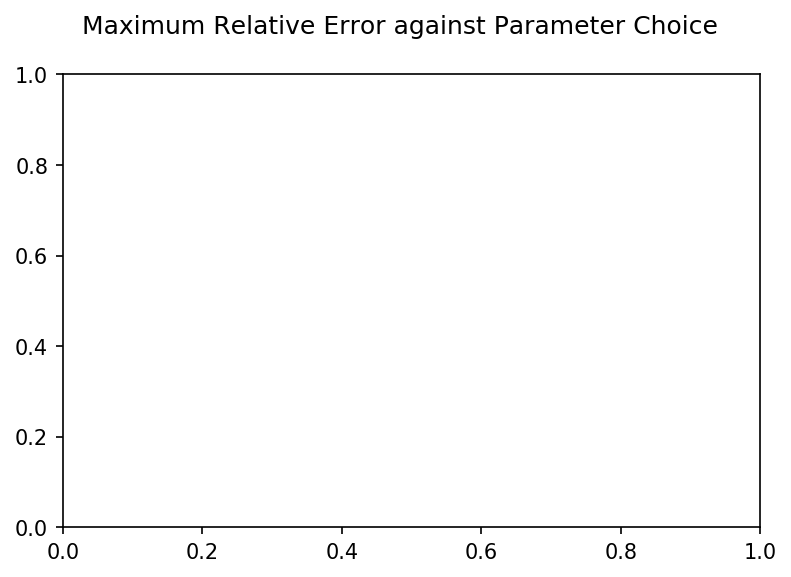

In [20]:
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)


amp = np.arange(.7,.92,.02)
width = np.arange(.9,1.12,.02) 
w_grid,a_grid = np.meshgrid(width,amp)
fig.suptitle('Maximum Relative Error against Parameter Choice')
ax1.set_title('Min Error: {:.5}%,  Max Error: {:.5}%'.format(np.amin(max_re[0]), np.amax(max_re[0])))
z1 = ax1.pcolormesh(a_grid,w_grid, max_re[0,:,:], shading = 'auto', norm=colors.LogNorm(vmin=.1, vmax=10))

for i in range(P.shape[0]):
    ax1.scatter(P[i,0]+.01, P[i,1]+.01, color = 'k', marker = 'x')

ax1.set_xlim(.68,.94) 
ax1.set_ylim(.86,1.14) 
ax1.legend(['Training Values'], loc = 8)
fig.colorbar(z1, ax = ax1)

ax1.set_ylabel('Width')
ax1.set_xlabel('Height')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
fig.suptitle('Maximum Relative Error against Parameter Choice')
ax1.set_title('Min Error: {:.5}%,  Max Error: {:.5}%'.format(np.amin(max_re[1]), np.amax(max_re[1])))
z1 = ax1.pcolormesh(a_grid,w_grid, max_re[1,:,:], shading = 'auto', norm=colors.LogNorm(vmin=.1, vmax=10))

for i in range(P.shape[0]):
    ax1.scatter(P[i,0]+.01, P[i,1]+.01, color = 'k', marker = 'x')

ax1.set_xlim(.69,.94) 
ax1.set_ylim(.86,1.14) 
ax1.legend(['Training Values'], loc = 8)
fig.colorbar(z1, ax = ax1)

ax1.set_ylabel('Width')
ax1.set_xlabel('Height')

In [ ]:
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax = plt.axes()
for i in range(2,sample+1):
    ax.plot([i,i], [adapt_values[0,i-2], adapt_values[1,i-2]], 'b-o')
    ax.plot([i,i], [adapt_values[2,i-2], adapt_values[3,i-2]], 'r-o')
    if i == 2:
        ax.plot(np.arange(2,sample+1), speed_up_avg[0], 'b-x', alpha = .5)
        ax.plot(np.arange(2,sample+1), speed_up_avg[0],'r-x', alpha = .5)
ax.set_yscale('log')
ax.set_ylim(.001,10000)
ax.legend(['Approximate IC', 'Exact IC', 'Approximate IC Speed up', 'Exact IC Speed up'])
ax.set_xlabel('Number of Points in Dynamics')
ax.set_ylabel('Relative Error (%)')
ax.set_title('Relative Predicitve Error Range for Various Training Values')
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
time_FOM/time_SINDy

In [ ]:
time_FOM

In [ ]:
plt.plot(test)